# Table of Contents
- [Goal](#Goal)
- [Problem](#problem)
- [Dataset](#dataset)
- [Model](#model)
  - [Train](#train)
  - [Test(Evaluate)](#testevaluate)
  - [Comparing scores before and after fine-tuning](#comparing-scores-before-and-after-fine-tuning)
  - [How to use the trained model](#how-to-use-the-trained-model)
  - [Publishing the trained model to Kaggle](#publishing-the-trained-model-to-kaggle)
- [Checking if the problem has been solved](#chekcing-if-the-problem-has-been-solved)
- [Limitations](#limitations)
- [Contact and Githup](#contact-and-github)

# Goal
- The goal of this project is to enhance gemma2 so that it can be used for the `study of Korean History` by enabling it to translate `hanja(Traditional Korean Chinese characters)` into `hangul(modern Korean characters)`.
  - A Hanja (한자, 漢字) is a very traditional Chinese character that was historically adopted into the Korean writing system, used to represent meanings or sounds, and is still employed today for clarity, academic purposes, and cultural heritage, often complementing Hangul in certain contexts. Almost of all traditional Korean scholar books were written in Hanja.
  - A Hangul (한글) is the Korean alphabet, a phonetic writing system invented in 1443 by King Sejong and his scholars during the Joseon Dynasty, designed to be simple and logical, enabling people of all social classes to easily learn and express the Korean language.
- In order to do this, I will show you
  - the `problem` of gemma2 is that it cannot translate `hanja` into `Korean` properly, whereas chatgpt-4o can.
  - how to collect the data(silok) for training - it takes about three weeks to crawl the whole data without multiprocessing.
    - Question: Which one is bigger, (a) the number of characters in [Silok(Korea)](https://en.wikipedia.org/wiki/Veritable_Records_of_the_Joseon_Dynasty), (b) the number of characters in [Twenty-Four Historis(China)](https://en.wikipedia.org/wiki/Twenty-Four_Histories)
    - Hint: `Silok` refers to the raw data of the Joseon Dynasties, whereas the `Twenty-Four Histories` are more like summarized versions. The total size of the Silok is just under 1GB.
  - how to publish the data to Kaggle
  - how to fine-tunning the gemma2
  - how to evaluate and use the model
  - how to publish the model to Kaggle
- Still working on it.

# Problem
- Gemma2 cannot translate `hanja(Korean Chinese)` into `modern Korean` properly without or with a few-shot prompt.
- Run the following code and check its result to identify the problem.

## Prepare to run gemma2

In [3]:
import os
from IPython.core.display import display, HTML

# Set the backbend before importing Keras
# os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

model_id = "gemma2_instruct_2b_en"

/tmp/ipykernel_23/3861638892.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Check the problem
- The `input` data was extracted from `태조실록1권 태조1년 7월 17일 병신 2번째기사(Korean Dynasty First King's records)`. The answer should be `answer`, but the result(model's best output among five different attempts) is `output`, indicating that the meanings of the answer and the output are very different(and actually wrong).
- `input`: `'上在潛邸, 夢有神人執金尺自天而降, 授之曰: "慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!"'`
- `answer`: `'임금이 잠저(潛邸)에 있을 때, 꿈에 신인(神人)이 금자[金尺]를 가지고 하늘에서 내려와 주면서 말하기를, "시중(侍中) 경복흥(慶復興)은 청렴하기는 하나 이미 늙었으며, 도통(都統) 최영(崔瑩)은 강직하기는 하나 조금 고지식하니, 이것을 가지고 나라를 바룰 사람은 공(公)이 아니고 누구이겠는가?" 하였다.'`
- `output`(model's output): `상을 잠들고, 꿈에 신인이 돈을 잡아 천장에서 내려왔다. 그에게 말했다: "정실 중, 복흥을 이루고, 깨끗해졌다. 崔都통 瑩, 곧 똑똑해졌지만, 멍청해졌다. 이 정권을 지키는 것은 공적인 일이 아니야!"`

## ChatGPT(4o)'s Output
- prompt: `한국의 한자로 된 고어 문서를 현대 한국어로 번역해줘. 영어나 중국어를 쓰지 말고 한글로 답변해줘. '上在潛邸, 夢有神人執金尺自天而降, 授之曰: "慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!"'`
- output:
다음은 고어로 된 문장을 현대 한국어로 번역한 내용입니다.

`"임금께서 잠시 머물던 곳에서 꿈을 꾸었는데, 신령스러운 사람이 금자(금으로 만든 자)를 들고 하늘에서 내려와 말하기를, '경 시중(慶侍中)은 나라를 다시 일으킬 만하나, 맑기는 하지만 나이가 많다. 최 도통(崔都統)은 정직하지만 조금 우둔하다. 이 자로 나라를 바로잡을 사람이 공(公)이 아니면 누가 있겠는가!'라고 하였다."`

배경 설명:

"상재잠저(上在潛邸)": 임금이 왕위에 오르기 전 거처하던 곳.
"시중(侍中)": 고려나 조선시대의 고위 관직.
"도통(都統)": 군사 직위나 관직.
"공(公)": 존칭으로, 높은 관직이나 인물을 지칭.
문맥에서 신령이 왕에게 꿈에서 금자를 주며 나라를 바로잡을 임무를 맡기는 장면으로 보입니다.

In [4]:
import keras
import keras_nlp
import time
import pandas as pd

gemma = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [5]:
test_hanja = '上在潛邸, 夢有神人執金尺自天而降, 授之曰: "慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!"'
test_answer = '임금이 잠저(潛邸)에 있을 때, 꿈에 신인(神人)이 금자[金尺]를 가지고 하늘에서 내려와 주면서 말하기를, "시중(侍中) 경복흥(慶復興)은 청렴하기는 하나 이미 늙었으며, 도통(都統) 최영(崔瑩)은 강직하기는 하나 조금 고지식하니, 이것을 가지고 나라를 바룰 사람은 공(公)이 아니고 누구이겠는가?" 하였다.'

In [6]:
tick_start = 0
token_limit = 512 

# https://www.kaggle.com/code/bebechien/translator-of-old-korean-literature
def text_gen(prompt):
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma.generate(input, max_length=token_limit)
    return output 


# kcy4, 2025.01.04
def text_gen_with_few_shot(prompt, few_shot):
    few_shot_str = ""
    for x, y in few_shot:
        few_shot_str += f"<start_of_turn>user\n{x}<end_of_turn>\n<start_of_turn>model\n{y}<end_of_turn>\n"
        
    input = f"{few_shot_str}<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma.generate(input, max_length=token_limit)
    # Get the last response from the model
    last_index = output.rfind("<start_of_turn>user")
    output = output[last_index:]
    return output 

In [7]:
# The output is totaly wrong, which says the input is a classic Chinese poem
test_output = text_gen(test_hanja)
test_output

'<start_of_turn>user\n上在潛邸, 夢有神人執金尺自天而降, 授之曰: "慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!"<end_of_turn>\n<start_of_turn>model\nThis is a classic Chinese poem, likely from the Tang Dynasty, known for its poetic imagery and philosophical depth. Let\'s break down its meaning:\n\n**The Context:**\n\n* **"上在潛邸"**:  This means the speaker is in a secluded, hidden place, possibly a mountaintop or a cave. This setting suggests a contemplative and introspective mood.\n* **"夢有神人執金尺自天而降"**:  This is a dream. A divine person, possibly a god or a wise sage, descends from the sky with a golden ruler. \n* **"授之曰: \'慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!\'"**:  The divine person gives the speaker a golden ruler. The message is delivered in a series of pronouncements:\n\n    * **"慶侍中 復興, 淸矣而已老"**:  "The Prime Minister, who is now in decline, can be revived. It is only a matter of time." This suggests a call for revitalization and renewal.\n    * **"崔都統 瑩, 直矣而少戇"**: "The Prime Minister, who is now in de

In [8]:
text_gen(f'한국의 한자로 된 고어 문서를 현대 한국어로 번역해줘. {test_hanja}')

'<start_of_turn>user\n한국의 한자로 된 고어 문서를 현대 한국어로 번역해줘. 上在潛邸, 夢有神人執金尺自天而降, 授之曰: "慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!"<end_of_turn>\n<start_of_turn>model\n## Translation of the Korean Hanja Text:\n\n**"Above the subterranean dwelling, there was a dream of a divine man holding a golden ruler that descended from heaven. He said, \'This is the way to restore the country, to revive it. It is only old; the Prime Minister of the Imperial Court, Choi, is wise and intelligent. Holding this, one can restore the country, not for the sake of the public, but for whom?\'"**\n\n\n**Explanation:**\n\nThis text is a fragment of a historical document, likely a conversation between a powerful figure and a subordinate. \n\n* **"Above the subterranean dwelling"**: This likely refers to a hidden or secret location, possibly a palace or a place of power.\n* **"there was a dream of a divine man holding a golden ruler that descended from heaven"**: This suggests a vision or prophecy, possibly about a future 

In [9]:
text_gen(f'한국의 한자로 된 고어 문서를 현대 한국어로 번역해줘. 영어나 중국어를 쓰지 말고 한글로 답변해줘. {test_hanja}')

'<start_of_turn>user\n한국의 한자로 된 고어 문서를 현대 한국어로 번역해줘. 영어나 중국어를 쓰지 말고 한글로 답변해줘. 上在潛邸, 夢有神人執金尺自天而降, 授之曰: "慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!"<end_of_turn>\n<start_of_turn>model\n**상을 잠들고, 꿈에 신인이 돈을 잡아 천장에서 내려왔다. 그에게 말했다: "정실 중, 복흥을 이루고, 깨끗해졌다. 崔都통 瑩, 곧 똑똑해졌지만, 멍청해졌다. 이 정권을 지키는 것은 공적인 일이 아니야!"** \n<end_of_turn>'

## Few-shot prompt

In [10]:
few_shot = [
    ('庚午朔/隕霜。', '경오삭(庚午朔)에 서리가 내리었다.'),
    ('壬申/上坐東涼廳, 召閱擲石軍, 命中樞趙琦領之。', '임금이 동량청(東涼廳)에 앉아 척석군(擲石軍)을 불러 사열하고, 중추(中樞) 조기(趙琦)에게 명하여 이들을 거느리게 하였다.'),
    ('都評議使司具戶曹給田司田制, 狀申, 上允之。', '도평의사사에서 호조 급전사(戶曹給田司)의 전제(田制)를 갖추어 장계(狀啓)로 아뢰니, 임금이 그대로 윤허하였다.')
]

text_gen_with_few_shot(test_hanja, few_shot)

'<start_of_turn>user\n上在潛邸, 夢有神人執金尺自天而降, 授之曰: "慶侍中 復興, 淸矣而已老; 崔都統 瑩, 直矣而少戇。 持此正國, 非公而誰!"<end_of_turn>\n<start_of_turn>model\n왕은 잠자리에 있었는데, 꿈에서 신성한 인물이 금 척을 땅에서 떨어뜨렸고, 그에게 말했다: "정신을 갖추고, 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨끗하게 만들어야 한다. 옛날의 힘을 되찾아, 깨'

In [11]:
test_hanja = '詣懿陵, 親祭, 仍詣貞陵, 親祭。'
text_gen_with_few_shot(test_hanja, few_shot)  # https://sillok.history.go.kr/id/kza_10608010_001
# Answer: 의릉(懿陵)에 나아가 친히 제사를 지냈다. 이어 정릉(貞陵)에 나아가 친히 제사를 지냈다.

'<start_of_turn>user\n詣懿陵, 親祭, 仍詣貞陵, 親祭。<end_of_turn>\n<start_of_turn>model\n이성릉(懿陵)에 가서 숭배하고, 다시 숭배를 했다. \n<end_of_turn>'

In [12]:
test_answer

'임금이 잠저(潛邸)에 있을 때, 꿈에 신인(神人)이 금자[金尺]를 가지고 하늘에서 내려와 주면서 말하기를, "시중(侍中) 경복흥(慶復興)은 청렴하기는 하나 이미 늙었으며, 도통(都統) 최영(崔瑩)은 강직하기는 하나 조금 고지식하니, 이것을 가지고 나라를 바룰 사람은 공(公)이 아니고 누구이겠는가?" 하였다.'

# Environment
- To understand the flow(or concept) of this program, this Kaggle notebook(environment) is sufficient.
- However, if you want to crawl the entire data and fully train gemma2 on your own, you will need
  - A PC with at least a RTX-3090 or more or better GPUs for fast training
  - python(>= 3.10) and conda installed
  - ```python -m pip install -r ./requirements```
  - to check my [github](https://github.com/cy4ego/google-unlock-global-communicateion-with-gemma)

# Dataset

## Prepare data to train

### Get all json filepaths

In [14]:
import json
import glob 

filepaths = sorted(glob.glob('/kaggle/input/joseon-dynasty-silok/*.jsonl'))
train_filepaths = filepaths[:21]
valid_filepaths = filepaths[21:23]
test_filepaths = filepaths[23:]

print(f"total number of train data: {len(train_filepaths)}\ntotal number of valid data: {len(valid_filepaths)}\ntotal number of test data: {len(test_filepaths)}")

total number of train data: 21
total number of valid data: 2
total number of test data: 2


### Json to TFRecord utils

In [15]:
import tensorflow as tf 
tf.__version__

'2.16.1'

In [16]:
# 1. Convert JSONL to TFRecords
def jsonl_to_tfrecord(jsonl_files, tfrecord_file):
    def serialize_example(data):
        feature = {
            "hanja": tf.train.Feature(bytes_list=tf.train.BytesList(value=[data["hanja"].encode("utf-8")])),
            "hangul": tf.train.Feature(bytes_list=tf.train.BytesList(value=[data["hangul"].encode("utf-8")])),
        }
        return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for file in jsonl_files:
            with open(file, "r") as f:
                for line in f:
                    data = json.loads(line.strip())
                    tf_example = serialize_example(data)
                    writer.write(tf_example)

# 2. Create a TFRecord dataset loader
def parse_tfrecord_fn(example_proto):
    feature_description = {
        "hanja": tf.io.FixedLenFeature([], tf.string),
        "hangul": tf.io.FixedLenFeature([], tf.string),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    return parsed_example["hanja"], parsed_example["hangul"]

def create_dataset(tfrecord_files, batch_size):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

    dataset = (raw_dataset
               .map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
               # .map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
               .shuffle(buffer_size=1_000)
               .batch(batch_size)
               .repeat()
               .prefetch(buffer_size=tf.data.AUTOTUNE))
    return dataset

### Create a TFRecord file from json filepaths

In [17]:
num_train_files = 2

train_filepaths = train_filepaths[:num_train_files] 

# File paths and parameters
train_tfrecord_file = "train_data.tfrecord"
valid_tfrecord_file = "valid_data.tfrecord"
test_tfrecord_file = "test_data.tfrecord"

# Convert JSONL files to TFRecord
filepaths = (train_filepaths, valid_filepaths, test_filepaths)[:-1]
tfrecord_files = (train_tfrecord_file, valid_tfrecord_file, test_tfrecord_file)[:-1]

for jsonl_files, tfrecord_file in zip(filepaths, tfrecord_files):
    print('Transforming jsonl files into tfrecord_file')
    jsonl_to_tfrecord(jsonl_files, tfrecord_file) 
    print(f"num_transformed_files={len(jsonl_files)}, tfrecord_file={tfrecord_file}")

Transforming jsonl files into tfrecord_file
num_transformed_files=2, tfrecord_file=train_data.tfrecord
Transforming jsonl files into tfrecord_file
num_transformed_files=2, tfrecord_file=valid_data.tfrecord


### Evaluate before fine-tuning

In [18]:
print(f"num test files: {len(test_filepaths)}")
# Load test data
test_data = []
for filepath in test_filepaths:
    with open(filepath, "r") as f:
        test_data.extend([json.loads(line.strip()) for line in f])
print(f"num test sample: {len(test_data)}")

# Use partial data in Kaggle environment
test_data = test_data[:30]

test_hanja = [e["hanja"] for e in test_data]
test_hangul = [e["hangul"] for e in test_data]
test_data = pd.DataFrame({"hanja": test_hanja, "answer": test_hangul})

num test files: 2
num test sample: 9743


In [19]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

In [20]:
# Trần Văn Nhân's notebooke
def extract_response(output):
    start_marker = "<start_of_turn>model\n"
    end_marker = "<end_of_turn>"
    
    start_idx = output.rfind(start_marker) + len(start_marker)  # kcy4, find > rfind due to few-shot
    end_idx = output.rfind(end_marker, start_idx)               # kcy4, find > rfind due to few-shot
    
    if start_idx != -1 and end_idx != -1:
        return output[start_idx:end_idx].strip()
    return output 


def gemma_score(df: pd.DataFrame, score_fn):
    scores = []
    try:
        function_name = score_fn.__name__
    except AttributeError:
        function_name = score_fn.__class__.__name__ 
    finally:
        is_rouge = function_name.lower().startswith('rouge')
            
    for _, row in df.iterrows():
        answer = row['answer']
        prediction = row['predict']
        if is_rouge:
            score = score_fn.score(answer, prediction)
        else:
            score = score_fn([answer.split()], prediction.split())
        
        scores.append(score)

    if is_rouge:
        rouge1_avg = sum([score['rouge1'].fmeasure for score in scores]) / len(scores)
        rouge2_avg = sum([score['rouge2'].fmeasure for score in scores]) / len(scores)
        rougeL_avg = sum([score['rougeL'].fmeasure for score in scores]) / len(scores)
        return rouge1_avg, rouge2_avg, rougeL_avg 
    else:
        return sum(scores) / len(scores)


def meteor_score_eval(df: pd.DataFrame):
    meteor_scores = []

    for i, row in df.iterrows():
        answer = row['answer']
        prediction = row['predict']
        score = meteor_score([answer.split()], prediction.split())
        meteor_scores.append(score)

    return sum(meteor_scores) / len(meteor_scores)

In [21]:
test_data["predict"] = test_data["hanja"].apply(lambda x: extract_response(text_gen_with_few_shot(x, few_shot)))

In [22]:
test_data.head(2)

,hanja,answer,predict
0,"○己卯/上卽位于崇政門。 奉王大妃, 行垂簾聽政禮于興政堂, 受朝賀頒敎, 大赦。",임금이 숭정문(崇政門)에서 즉위하였다. 왕대비(王大妃)를 받들어 수렴 청정(垂簾聽政...,"<start_of_turn>user\n○己卯/上卽位于崇政門。 奉王大妃, 行垂簾聽政禮..."
1,"○王大妃敎曰:主上旣登大位, 追崇應行典禮。 該曹擇日擧行。","왕대비가 하교(下敎)하기를,""주상(主上)이 이미 대위(大位)에 올랐으니, 추숭(追崇...","왕대비(王大妃)는 ""주상이 이미 대위에 올랐을 때, 숭배하는 행위를 갖추어야 한다...."


In [23]:
score_names = ('BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR')
before_scores = []
before_scores.append(gemma_score(test_data, score_fn=sentence_bleu))
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
before_scores.extend(list(gemma_score(test_data, score_fn=scorer)))
before_scores.append(gemma_score(test_data, score_fn=meteor_score))
before_scores_df = pd.DataFrame({'metric': score_names, 'before': before_scores})
before_scores_df

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

,metric,before
0,BLEU,4.207556e-156
1,ROUGE-1,4.444444e-03
2,ROUGE-2,0.000000e+00
3,ROUGE-L,4.444444e-03
4,METEOR,4.359667e-02


# Model
- `google/gemma-2-2b-it`

## Train
- reference : 

### Configuration

In [24]:
# Training Configurations
debug = True
lora_name = "hanja2hangul"
lora_rank = 4
lr_value = 1e-4
train_epoch = 4 if debug else 5
batch_size = 1  # 2 throws OOM error
max_length = 512

### Tokenizer

In [25]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

### Compile model

In [26]:
# https://www.kaggle.com/code/bebechien/translator-of-old-korean-literature
# # Enable LoRA for the model and set the LoRA rank (4, 8 or 16).
gemma.backbone.enable_lora(rank=lora_rank)
gemma.summary()

# Limit the input sequence length (to control memory usage).
gemma.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

### Train model

In [27]:
# dataset 
train_dataset = create_dataset(train_tfrecord_file, batch_size)
valid_dataset = create_dataset(valid_tfrecord_file, batch_size)

if debug:
    train_dataset = train_dataset.take(1000)
    valid_dataset = valid_dataset.take(100)
    

In [28]:
# callbacks
checkpoint_filepath = f"/kaggle/working/{lora_name}_{lora_rank}_best.lora.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1, 
)

In [29]:
# train 
history = gemma.fit(train_dataset, validation_data=valid_dataset, epochs=train_epoch, callbacks=[checkpoint_callback])

Epoch 1/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - loss: 0.8251 - sparse_categorical_accuracy: 0.2431
Epoch 1: val_loss improved from inf to 1.38940, saving model to /kaggle/working/hanja2hangul_4_best.lora.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 969s 938ms/step - loss: 0.8250 - sparse_categorical_accuracy: 0.2431 - val_loss: 1.3894 - val_sparse_categorical_accuracy: 0.2404
Epoch 2/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - loss: 0.6744 - sparse_categorical_accuracy: 0.2933
Epoch 2: val_loss improved from 1.38940 to 1.38844, saving model to /kaggle/working/hanja2hangul_4_best.lora.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 928s 910ms/step - loss: 0.6744 - sparse_categorical_accuracy: 0.2933 - val_loss: 1.3884 - val_sparse_categorical_accuracy: 0.2487
Epoch 3/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - loss: 0.6210 - sparse_categorical_accuracy: 0.3152
Epoch 3: val_loss did not improve from 1.38844
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 857s 857ms/step - loss: 0.6209 - sparse_categorical_accu

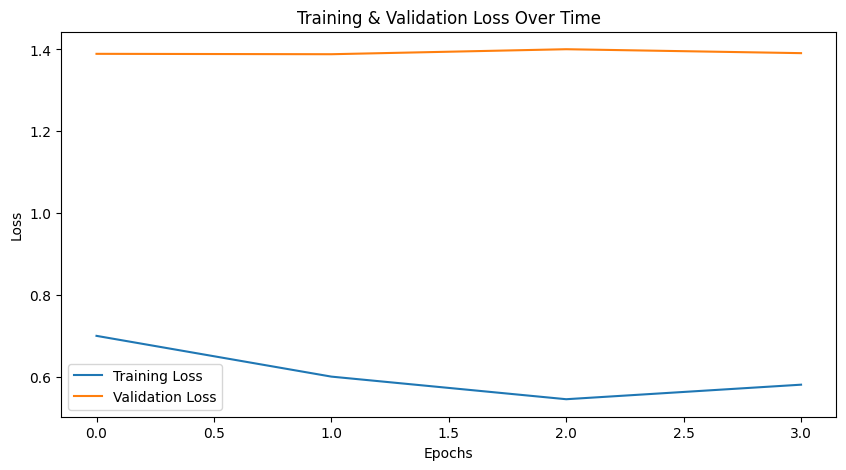

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Time')
plt.legend()
plt.show()

## Test(Evaluate)
- There are many evaluation methods. Refer to this [A list of metrics for evaluating LLM-generated content](https://learn.microsoft.com/en-us/ai/playbook/technology-guidance/generative-ai/working-with-llms/evaluation/list-of-eval-metrics) for more details.
  - Check [Trần Văn Nhân's notebooke](https://www.kaggle.com/code/tranvannhan1911/gemma-2-fine-tuning-to-translate-old-vietnamese#Evaluate) to evaluate in a Kaggle notebook using basic metrics.
- According to recent research, it is recommended to use `LLMs as a judge`. I will upload this to my github project.
- I just check it manually in this environment.

### Evaluate manually

In [31]:
# 5. Test the model manually 
def test_model(test_data):
    for count, entry in test_data.iterrows():
        hanja = entry["hanja"]
        hangul_expected = entry["answer"]

        # Generate predictions
        predicted_without_fewshot_prompt = text_gen(hanja) 
        predicted_with_fewshot_prompt = text_gen_with_few_shot(hanja, few_shot)

        print(f"Hanja: \n{hanja}")
        print(' - ' * 30)
        print(f"Expected Hangul: \n{hangul_expected}")
        print(' - ' * 30)
        print(f"Predicted Hangul(/wo fewshot): \n{predicted_without_fewshot_prompt}")
        print(' - ' * 30)
        print(f"Predicted Hangul(/w fewshot): \n{predicted_with_fewshot_prompt}")
        print("= " * 50)

        if count > 3:
            break 


In [32]:
# Load best weights
gemma.load_weights(checkpoint_filepath)

In [33]:
test_model(test_data)

Hanja: 
○己卯/上卽位于崇政門。 奉王大妃, 行垂簾聽政禮于興政堂, 受朝賀頒敎, 大赦。
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Expected Hangul: 
임금이 숭정문(崇政門)에서 즉위하였다. 왕대비(王大妃)를 받들어 수렴 청정(垂簾聽政)의 예(禮)를 흥정당(興政堂)에서 행하고, 조하(朝賀)를 받은 다음 교서(敎書)를 반포(頒布)하고 대사(大赦)를 베풀었다.
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Predicted Hangul(/wo fewshot): 
<start_of_turn>user
○己卯/上卽位于崇政門。 奉王大妃, 行垂簾聽政禮于興政堂, 受朝賀頒敎, 大赦。<end_of_turn>
<start_of_turn>model
This is a passage from a historical record, likely from a Chinese dynasty's official annals. Let's break down the meaning:

**○己卯/上卽位于崇政門.**

* **○己卯:** This refers to the date, which is the 10th day of the 5th month in the lunisolar calendar. 
* **上卽位于崇政門:** This means "The Emperor ascended to the Chongzheng Gate." The Chongzheng Gate was a ceremonial entrance to the palace, and its use for the Emperor's ascension signifies a significant event.

**奉王大妃, 行垂簾聽政禮于興政堂, 受朝賀頒敎, 大赦。**

* **奉王大妃:** This tran

In [34]:
test_hanja = '詣眞殿, 行茶禮。'
text_gen(test_hanja)  # https://sillok.history.go.kr/id/kza_10201001_001
# Answer: 진전(眞殿)에 가서 다례(茶禮)를 지냈다. (고종2년 1월)

'<start_of_turn>user\n詣眞殿, 行茶禮。<end_of_turn>\n<start_of_turn>model\nThis is a line from a Chinese poem, and it translates to:\n\n**"To the True Hall, I pay my respects with tea ceremony."**\n\nHere\'s a breakdown:\n\n* **詣眞殿:**  "To the True Hall" - This refers to the main hall of a palace, often used for ceremonies and important events. \n* **行茶禮:** "To perform the tea ceremony" - This refers to the traditional ritual of serving tea, which is a sign of respect and hospitality in Chinese culture. \n\nThe line is a poetic way of expressing the importance of the tea ceremony as a respectful act of visiting a place of power and importance. \n<end_of_turn>'

In [35]:
text_gen_with_few_shot(test_hanja, few_shot)  # https://sillok.history.go.kr/id/kza_10201001_001
# Answer: 진전(眞殿)에 가서 다례(茶禮)를 지냈다. (고종2년 1월)

'<start_of_turn>user\n詣眞殿, 行茶禮。<end_of_turn>\n<start_of_turn>model\n진궁에 詣하여 차례를 갖추었다. \n<end_of_turn>'

In [36]:
test_hanja = '凡我在廷, 咸須知悉, 諧底大道, 同此太平。 是予之望也。'
text_gen(test_hanja)  # https://sillok.history.go.kr/id/kza_10201001_003, end of the text 
# Answer: 우리 조정에 있는 모든 신료들은 다 잘 알아서 모두 대도(大道)에 이르고 함께 이 태평을 누리도록 하라. 이것이 나의 바람이다. (고종2년 1월)

'<start_of_turn>user\n凡我在廷, 咸須知悉, 諧底大道, 同此太平。 是予之望也。<end_of_turn>\n<start_of_turn>model\nThis is a powerful and evocative quote from the Chinese philosopher and statesman, **Confucius**. \n\nHere\'s a breakdown of its meaning and significance:\n\n* **"凡我在廷, 咸須知悉, 諧底大道, 同此太平。"** \n    * **凡我在廷:**  "Wherever I am in the court." This emphasizes the importance of the ruler\'s presence and influence.\n    * **咸須知悉:** "Must be aware of all things." This highlights the need for a ruler to be informed and attentive to all aspects of governance.\n    * **諧底大道:** "Harmonize the fundamental principles." This refers to the importance of adhering to the core principles of governance, ethics, and social order.\n    * **同此太平:** "To ensure peace and stability." This is the ultimate goal of a ruler who understands and upholds the principles of governance.\n\n**Translation:** "Wherever I am in the court, I must be aware of all things, harmonize the fundamental principles, and ensure peace and stability.

In [37]:
text_gen_with_few_shot(test_hanja, few_shot)  # https://sillok.history.go.kr/id/kza_10201001_003, end of the text 
# Answer: 우리 조정에 있는 모든 신료들은 다 잘 알아서 모두 대도(大道)에 이르고 함께 이 태평을 누리도록 하라. 이것이 나의 바람이다. (고종2년 1월)

'<start_of_turn>user\n凡我在廷, 咸須知悉, 諧底大道, 同此太平。 是予之望也。<end_of_turn>\n<start_of_turn>model\n나는 궁궐에 있을 때, 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 '

In [38]:
test_hanja = '詣懿陵, 親祭, 仍詣貞陵, 親祭。'
text_gen(test_hanja)  # https://sillok.history.go.kr/id/kza_10608010_001
# Answer: 의릉(懿陵)에 나아가 친히 제사를 지냈다. 이어 정릉(貞陵)에 나아가 친히 제사를 지냈다.

'<start_of_turn>user\n詣懿陵, 親祭, 仍詣貞陵, 親祭。<end_of_turn>\n<start_of_turn>model\nThis is a passage from the Chinese text of the "Records of the Grand Historian" (史記), written by Sima Qian during the Han dynasty. It describes the ritual of offering sacrifices to the ancestors at the tombs of Emperor Wu of the Han dynasty and his consort, Empress Dowager Dou. \n\nHere\'s a breakdown:\n\n* **詣懿陵, 親祭:** This phrase translates to "To the tomb of Emperor Wu, I offer a personal sacrifice." \n* **仍詣貞陵, 親祭:** This phrase translates to "And to the tomb of Empress Dowager Dou, I offer a personal sacrifice."\n\nThe passage highlights the importance of filial piety and ancestral worship in Chinese culture. It also emphasizes the respect and reverence shown towards the deceased emperors and empresses. \n\n**Context:**\n\n* **懿陵 (Yì Líng):** This is the tomb of Emperor Wu of the Han dynasty. \n* **貞陵 (Zhēng Líng):** This is the tomb of Empress Dowager Dou, wife of Emperor Wu. \n\nThe passage is a testame

In [39]:
test_hanja = '詣懿陵, 親祭, 仍詣貞陵, 親祭。'
text_gen_with_few_shot(test_hanja, few_shot)  # https://sillok.history.go.kr/id/kza_10608010_001
# Answer: 의릉(懿陵)에 나아가 친히 제사를 지냈다. 이어 정릉(貞陵)에 나아가 친히 제사를 지냈다.

'<start_of_turn>user\n詣懿陵, 親祭, 仍詣貞陵, 親祭。<end_of_turn>\n<start_of_turn>model\n임금은 懿릉에 詣, 숭배하고, 貞릉에 또 詣, 숭배하였다. \n\n\n<end_of_turn>'

### Evaluate after fine-tuning

In [40]:
test_data["predict"] = test_data["hanja"].apply(lambda x: extract_response(text_gen_with_few_shot(x, few_shot)))

In [41]:
after_scores = []
after_scores.append(gemma_score(test_data, score_fn=sentence_bleu))
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
after_scores.extend(list(gemma_score(test_data, score_fn=scorer)))
after_scores.append(gemma_score(test_data, score_fn=meteor_score))
after_scores_df = pd.DataFrame({'metric': score_names, 'after': after_scores})
after_scores_df

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

,metric,after
0,BLEU,1.888667e-232
1,ROUGE-1,0.000000e+00
2,ROUGE-2,0.000000e+00
3,ROUGE-L,0.000000e+00
4,METEOR,1.109924e-02


## Comparing scores before and after fine-tuning

In [42]:
scores_df = before_scores_df.merge(after_scores_df, on='metric', how='left')
scores_df

,metric,before,after
0,BLEU,4.207556e-156,1.888667e-232
1,ROUGE-1,4.444444e-03,0.000000e+00
2,ROUGE-2,0.000000e+00,0.000000e+00
3,ROUGE-L,4.444444e-03,0.000000e+00
4,METEOR,4.359667e-02,1.109924e-02


## Publishing the trained model to Kaggle
- ref: [Publish your Keras models on Kaggle and Hugging Face](https://developers.googleblog.com/en/publish-your-keras-models-on-kaggle-and-hugging-face/)

In [43]:
# Delete temporary files
!rm /kaggle/working/*.tfrecord
!rm /kaggle/working/*.h5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [44]:
# You can just the best weights from the .h5 file
# Don't need to run the following commands 
preset_dir = 'gemma2_inst_2b_hanja2hangul'
gemma.save_to_preset(preset_dir)
print(f"Model saved to: {preset_dir}")

Model saved to: gemma2_inst_2b_hanja2hangul


## How to use the trained model
- See my notebook, [how to use a trained model](https://www.kaggle.com/code/cy4ego/gemma2-how-to-use-a-trained-model)

# Checking if the problem has been solved
- Run the following code and check its result.
- The output closely resembles the answer.

In [45]:
test_hanja = '以李建弼爲吏曹參議。'
text_gen_with_few_shot(test_hanja, few_shot)  
# https://sillok.history.go.kr/id/kza_10208001_001 - 고종 2년 8월 1일 
# Answer: 이건필(李建弼)을 이조 참의(吏曹參議)로 삼았다.

'<start_of_turn>user\n以李建弼爲吏曹參議。<end_of_turn>\n<start_of_turn>model\n이건필(李建弼)을 吏曹의 좌찬(參議)에 임하였다. \n<end_of_turn>'

In [46]:
test_hanja = '議政府啓: "卽見咸鏡道暗行御使權命菊所奏, 則‘吉州人許活, 該牧別砲設置時, 以折米五百石, 輸助砲糧。’ 其向上之心, 可以激勸事, 批旨令廟堂稟處事, 命下矣。 嚮因道啓, 施以賞資之典, 而今於直指之歸奏, 益詳其所未詳。 其激奬之政, 不必以已有所施, 仍置不論。 五衛將, 爲先加設單付, 相當職隨窠調用何如?" 允之。'
text_gen_with_few_shot(test_hanja, few_shot)  
# https://sillok.history.go.kr/id/kza_10510013_002 - 고종 5년 10월 13일 
# Answer: 의정부(議政府)에서 아뢰기를, "방금 함경도 암행어사(咸鏡道暗行御史) 권명국(權命菊)이 아뢴 바를 보니, 길주(吉州) 사람 허활(許活)이 길주목(吉州牧)에 별포군(別砲軍)을 설치할 때에 절미(折米) 500석(石)을 실어다 별포군의 양식에 보태주었다고 합니다. 성상께 향한 그의 마음이 격려하고 권장할 만하다고 하였는데, 이에 대한 비지(批旨)에, 묘당(廟堂)으로 하여금 품처(稟處)하게 하라고 명하셨습니다. 전번에 도계(道啓)로 인하여 상으로 가자(加資)하는 은전을 시행하였는데, 지금 어사가 돌아와 아뢰어 자세하지 못했던 것이 더욱 자세해졌습니다. 격려하고 권장하는 정사를 이미 시행한 바가 있다고 하여 그대로 둔 채 논하지 않을 수 없습니다. 오위장(五衛將)을 먼저 가설(加設)해 단부(單付)하고 상당한 벼슬에 자리가 나는 대로 조용(調用)하는 것이 어떻겠습니까?"

'<start_of_turn>user\n議政府啓: "卽見咸鏡道暗行御使權命菊所奏, 則‘吉州人許活, 該牧別砲設置時, 以折米五百石, 輸助砲糧。’ 其向上之心, 可以激勸事, 批旨令廟堂稟處事, 命下矣。 嚮因道啓, 施以賞資之典, 而今於直指之歸奏, 益詳其所未詳。 其激奬之政, 不必以已有所施, 仍置不論。 五衛將, 爲先加設單付, 相當職隨窠調用何如?" 允之。<end_of_turn>\n<start_of_turn>model\n"당시 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은 혹은'

# Limitations
## Dataset
- Coverage
  - Only crawled `silok`(Korean Kings' records)
  - Can make it to be trainable to find reference or for NER

## Model
- Evaluation: Use other methods

# Version History
1. v1 - Baseline
2. v2 - Using the entire data for fine-tuning, adding comparing scores before and after fine-tuning and how to use the trained model.
   - Train gemma2 using the entire data after transforming jsonl files into tfrecord file
   - Add comparing scores(bleu, rouge, meteor) before and after fine-tuning
   - Add how to use the trained model(guide)
3. v3 - debug=True

# Contact
- Seongcheol Kim: kiscipher@gmail.com
- Github project: https://github.com/cy4ego/google-unlock-global-communicateion-with-gemma